In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

In [2]:
# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, RadioMaterial, LambertianPattern
# Import Sionna RT components
from sionna.ofdm import ResourceGrid, PilotPattern
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel
from sionna.nr import CarrierConfig, PUSCHDMRSConfig, TBConfig, PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, sim_ber

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

In [4]:
# Load blender scene
scene = load_scene("blender/scene.xml")
#scene = load_scene("blender/empty_scene.xml")

In [5]:
polycarbonate = RadioMaterial("polycarbonate",
                              relative_permittivity=3,
                              conductivity=0.001,
                              scattering_coefficient=0.3,
                              xpd_coefficient=0.1,
                              scattering_pattern=LambertianPattern())

cardboard  = RadioMaterial("cardboard",
                           relative_permittivity=2.3,
                           conductivity=0.001,
                           scattering_coefficient=0.3,
                           xpd_coefficient=0.1,
                           scattering_pattern=LambertianPattern())

plastic = RadioMaterial("plastic",
                        relative_permittivity=2.8,
                        conductivity=0.0001,
                        scattering_coefficient=0.3,
                        xpd_coefficient=0.1,
                        scattering_pattern=LambertianPattern())

ceramic  = RadioMaterial("ceramic",
                         relative_permittivity=6,
                         conductivity=0.0001,
                         scattering_coefficient=0.3,
                         xpd_coefficient=0.1,
                         scattering_pattern=LambertianPattern())

In [6]:
Polycarbonate_parts = scene.get("Polycarbonate_parts")
Paper_boxes = scene.get("Paper_boxes") 
Plastic_parts = scene.get("Plastic_parts")  
Ceramic_parts = scene.get("Ceramic_parts")

Polycarbonate_parts.radio_material = polycarbonate 
Paper_boxes.radio_material = cardboard 
Plastic_parts.radio_material = plastic 
Ceramic_parts.radio_material = ceramic

In [7]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1, #16
                             num_cols=1, #4
                             vertical_spacing=0.1,
                             horizontal_spacing=0.1,
                             pattern="tr38901",
                             polarization="H")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1, #16
                             num_cols=1, #16
                             vertical_spacing=0.1,
                             horizontal_spacing=0.1,
                             pattern="dipole",
                             polarization="H")

# Create transmitter
tx = Transmitter(name="tx",
                 color=tf.Variable((1, 0, 0), dtype=tf.float32),
                 position=tf.Variable([0.5,3,1], dtype=tf.float32), 
                 orientation=tf.Variable([0,0,0], dtype=tf.float32))

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              color=tf.Variable((1, 0, 0), dtype=tf.float32),
              position=tf.Variable([6.4,3,1], dtype=tf.float32),
              orientation=tf.Variable([0,0,0], dtype=tf.float32))

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver
rx.look_at(tx) # Receiver points towards transmitter 

In [8]:
scene.frequency = 60.48e9 # in Hz; implicitly updates RadioMaterials
scene.bandwidth = 512e6
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [9]:
# Compute propagation paths
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)  # Number of rays shot into directions defined
                                              # by a Fibonacci sphere , too few rays can
                                              # lead to missing paths

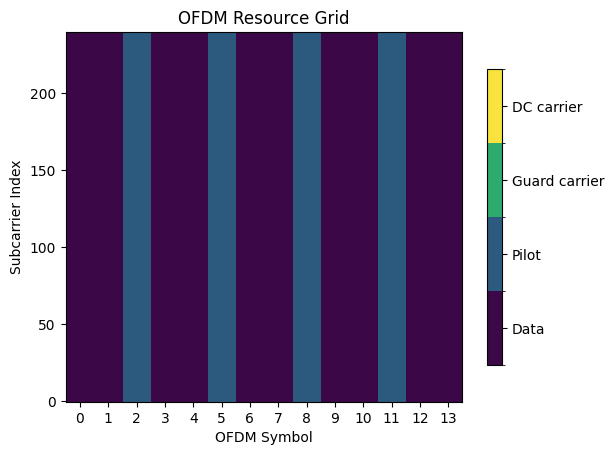

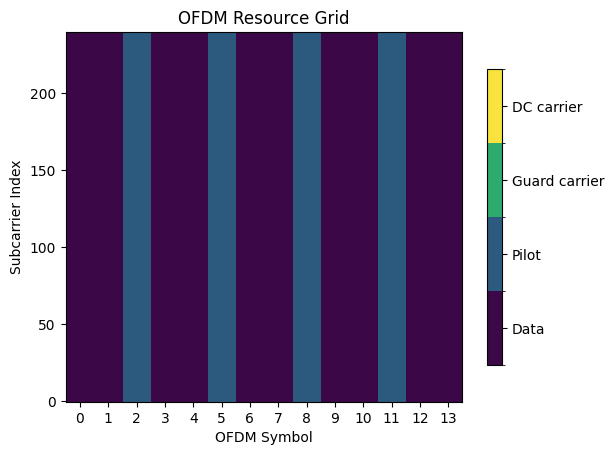

In [10]:
dmrs_config = PUSCHDMRSConfig(config_type=1)
dmrs_config.type_a_position = 2
dmrs_config.additional_position = 3


carrier_config = CarrierConfig()
carrier_config.num_subcarriers = 240

tb_config = TBConfig(mcs_index=2)
tb_config.mcs_table = 4
tb_config.channel_type = "PUSCH"
        
# PUSCHConfig 
pusch_config = PUSCHConfig(carrier_config=carrier_config,pusch_dmrs_config=dmrs_config,tb_config=tb_config)
pusch_config.num_slots_per_frame = 10
pusch_config.num_slots_per_subframe = 1 
pusch_config.num_symbols_per_slot = 14
pusch_config.sub_frame_duration = 0.001
pusch_config.carrier.subcarrier_spacing = 120e3/1000
pusch_config.n_size_bwp = 20 # We reduce the bandwidth to one PRB for better visualization

pusch_transmitter = PUSCHTransmitter(pusch_config)

pusch_transmitter.resource_grid.show()

In [11]:
pusch_config.show()

Carrier Configuration
cyclic_prefix : normal
cyclic_prefix_length : 1.1067708333333334e-06
frame_duration : 0.01
frame_number : 0
kappa : 64.0
mu : 3
n_cell_id : 1
n_size_grid : 4
n_start_grid : 0
num_slots_per_frame : 80
num_slots_per_subframe : 8
num_subcarriers : 240
num_symbols_per_slot : 14
slot_number : 0
sub_frame_duration : 0.001
subcarrier_spacing : 120.0
t_c : 5.086263020833334e-10
t_s : 3.2552083333333335e-08

PUSCH Configuration
dmrs_grid : shape (1, 240, 14)
dmrs_grid_precoded : shape ()
dmrs_mask : shape (240, 14)
dmrs_symbol_indices : [2, 5, 8, 11]
frequency_hopping : neither
l : [2, 5, 8, 11]
l_0 : 2
l_bar : [2, 5, 8, 11]
l_d : 14
l_prime : [0]
l_ref : 0
mapping_type : A
n : shape (60,)
n_rnti : 1
n_size_bwp : 20
n_start_bwp : 0
num_antenna_ports : 1
num_coded_bits : 4800
num_layers : 1
num_ov : 0
num_res_per_prb : 120
num_resource_blocks : 20
num_slots_per_frame : 10
num_slots_per_subframe : 1
num_subcarriers : 240
num_symbols_per_slot : 14
precoding : non-codebook
pre

In [12]:
# We need to enable sionna.config.xla_compat before we can use
# tf.function with jit_compile=True.
# See https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat
sn.config.xla_compat=False # not supported in CIRDataset

class Model(tf.keras.Model):
    """Simulate PUSCH transmissions over a 3GPP 38.901 model.
Test,
                 subcarrier_spacing,
                 num_bits_per_symbol,
                 a,
                 tau
                 
    Parameters
    ----------
    channel_model : :class:`~sionna.channel.ChannelModel` object
        An instance of a :class:`~sionna.channel.ChannelModel` object, such as
        :class:`~sionna.channel.RayleighBlockFading` or
        :class:`~sionna.channel.tr38901.UMi` or
        :class:`~sionna.channel.CIRDataset`.

    perfect_csi : bool
        Determines if perfect CSI is assumed or if the CSI is estimated

    detector : str, one of ["lmmse", "kbest"]
        MIMO detector to be used. Note that each detector has additional
        parameters that can be configured in the source code of the _init_ call.

    Input
    -----
    batch_size : int
        Number of simultaneously simulated slots

    ebno_db : float
        Signal-to-noise-ratio

    Output
    ------
    b : [batch_size, num_tx, tb_size], tf.float
        Transmitted information bits

    b_hat : [batch_size, num_tx, tb_size], tf.float
        Decoded information bits
    """
    def __init__(self,
                 Test,
                 subcarrier_spacing,
                 num_bits_per_symbol,
                 normalize,
                 paths
                ):
        
        super().__init__()
        
        self.Test = Test
        self.subcarrier_spacing = subcarrier_spacing
        self.num_bits_per_symbol = num_bits_per_symbol
        self.normalize = normalize

        self.paths = paths
        self.paths.normalize_delays = False
        a, tau = self.paths.cir()
        self.a = a
        self.tau = tau

        if self.Test == False:
            self.fft_size = 240
        else:
            self.fft_size = 48

        # Transport block Config
        if num_bits_per_symbol == 2: # QPSK
            mcs_index = 2
        elif num_bits_per_symbol == 4: # 16QAM
            mcs_index = 3
        elif num_bits_per_symbol == 6: # 64QAM
            mcs_index = 6
        elif num_bits_per_symbol == 8: # 256QAM
            mcs_index = 15
        elif num_bits_per_symbol == 10: # 1024QAM
            mcs_index = 23
        else:
            mcs_index = 3 # 16QAM
            
        tb_config = TBConfig(mcs_index=mcs_index)
        tb_config.mcs_table = 4
        tb_config.channel_type = "PUSCH"
        
        # PUSCHConfig 
        pusch_config = PUSCHConfig(tb_config=tb_config)
        pusch_config.num_slots_per_frame = 10
        pusch_config.num_slots_per_subframe = 1 
        pusch_config.num_symbols_per_slot = 14
        pusch_config.sub_frame_duration = 0.001
        pusch_config.carrier.num_subcarriers = self.fft_size
        pusch_config.carrier.subcarrier_spacing = self.subcarrier_spacing/1000

        if self.Test == False:
            pusch_config.n_size_bwp = 20

        # Instantiate a PUSCHTransmitter from the PUSCHConfig
        self._pusch_transmitter = PUSCHTransmitter(pusch_config)

        # Create a PUSCHReceiver using the PUSCHTransmitter
        self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter)

        # Init channel layer
        self._channel = ApplyOFDMChannel(add_awgn=True)
    
    # XLA currently not supported by the CIRDataset function
    @tf.function(jit_compile=False)
    def call(self, batch_size, ebno_db):

        # Compute frequencies of subcarriers and center around carrier frequency
        frequencies = subcarrier_frequencies(self.fft_size, self.subcarrier_spacing)
            
        # Compute the frequency response of the channel at frequencies.
        h_freq = cir_to_ofdm_channel(frequencies,
                                     self.a,
                                     self.tau,
                                     normalize=self.normalize) # Non-normalized includes path-loss

        x, b = self._pusch_transmitter(batch_size)
        
        no = ebnodb2no(ebno_db,
                       self._pusch_transmitter._num_bits_per_symbol,
                       self._pusch_transmitter._target_coderate,
                       self._pusch_transmitter.resource_grid)

        y = self._channel([x, h_freq, no]) # Simulate channel output
        b_hat = self._pusch_receiver([y, no])
  
        return b, b_hat

In [13]:
PUSCH_SIMS = {
    "num_bits_per_symbol" : [2,4,6,8,10],
    "subcarrier_spacing" : 120e3,
    "ebno_db" : np.concatenate((np.linspace(0, 70, num=15), np.linspace(71, 100, num=30))), #list(range(30, 60, 1)),
    "bler" : [],
    "ber" : []
    }

Test = True
normalize = False
batch_size = 128

for num_bits_per_symbol in PUSCH_SIMS["num_bits_per_symbol"]:
        
    model = Model(Test,
                  PUSCH_SIMS["subcarrier_spacing"], 
                  num_bits_per_symbol,
                  normalize,
                  paths)

    ber, bler = sim_ber(model,
                        PUSCH_SIMS["ebno_db"],
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    PUSCH_SIMS["ber"].append(list(ber.numpy()))
    PUSCH_SIMS["bler"].append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.9975e-01 | 1.0000e+00 |       70621 |      141312 |          256 |         256 |         8.4 |reached target block errors
      5.0 | 4.9899e-01 | 1.0000e+00 |       70513 |      141312 |          256 |         256 |         0.6 |reached target block errors
     10.0 | 4.9938e-01 | 1.0000e+00 |       70568 |      141312 |          256 |         256 |         0.6 |reached target block errors
     15.0 | 4.9942e-01 | 1.0000e+00 |       70574 |      141312 |          256 |         256 |         0.6 |reached target block errors
     20.0 | 4.9850e-01 | 1.0000e+00 |       70444 |      141312 |          256 |         256 |         0.6 |reached target block errors
     25.0 | 4.9742e-01 | 1.0000e+00 |       70291 |      141312 |

In [14]:
PUSCH_SIMS2 = {
    "num_bits_per_symbol" : [2,4,6,8,10],
    "subcarrier_spacing" : 120e3,
    "ebno_db" : np.linspace(-10, 20, num=61),
    "bler" : [],
    "ber" : []
    }

Test = True
normalize = True
batch_size = 128

for num_bits_per_symbol in PUSCH_SIMS2["num_bits_per_symbol"]:
        
    model = Model(Test,
                  PUSCH_SIMS2["subcarrier_spacing"], 
                  num_bits_per_symbol,
                  normalize,
                  paths)

    ber, bler = sim_ber(model,
                        PUSCH_SIMS2["ebno_db"],
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    PUSCH_SIMS2["ber"].append(list(ber.numpy()))
    PUSCH_SIMS2["bler"].append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.6223e-01 | 1.0000e+00 |       65319 |      141312 |          256 |         256 |         4.2 |reached target block errors
     -9.5 | 4.5742e-01 | 1.0000e+00 |       64639 |      141312 |          256 |         256 |         0.6 |reached target block errors
     -9.0 | 4.5453e-01 | 1.0000e+00 |       64230 |      141312 |          256 |         256 |         0.6 |reached target block errors
     -8.5 | 4.4553e-01 | 1.0000e+00 |       62959 |      141312 |          256 |         256 |         0.6 |reached target block errors
     -8.0 | 4.4131e-01 | 1.0000e+00 |       62362 |      141312 |          256 |         256 |         0.6 |reached target block errors
     -7.5 | 4.3669e-01 | 1.0000e+00 |       61709 |      141312 |

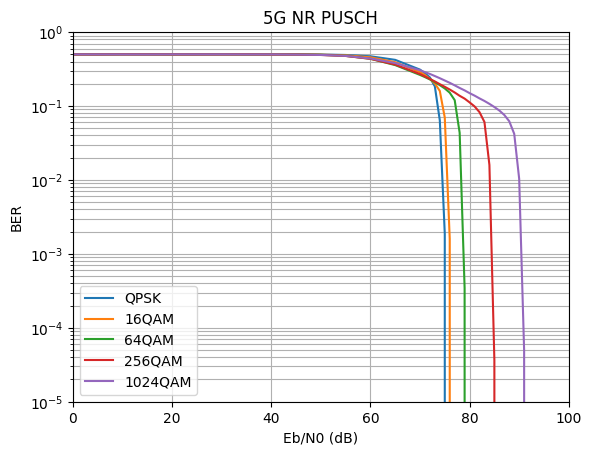

In [15]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([PUSCH_SIMS["ebno_db"][0], PUSCH_SIMS["ebno_db"][-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for num_bits_per_symbol in PUSCH_SIMS["num_bits_per_symbol"]:
    
    plt.semilogy(PUSCH_SIMS["ebno_db"], PUSCH_SIMS["ber"][i])
    i += 1
    if num_bits_per_symbol == 2:
        legend.append("QPSK")
    else:
        legend.append(str(2 ** num_bits_per_symbol) + "QAM")
    
plt.legend(legend);

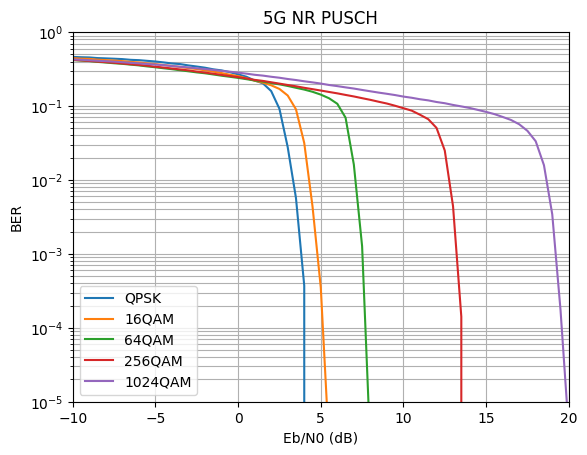

In [16]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([PUSCH_SIMS2["ebno_db"][0], PUSCH_SIMS2["ebno_db"][-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for num_bits_per_symbol in PUSCH_SIMS2["num_bits_per_symbol"]:
    
    plt.semilogy(PUSCH_SIMS2["ebno_db"], PUSCH_SIMS2["ber"][i])
    i += 1
    if num_bits_per_symbol == 2:
        legend.append("QPSK")
    else:
        legend.append(str(2 ** num_bits_per_symbol) + "QAM")
    
plt.legend(legend);

In [17]:
PUSCH_SIMS3 = {
    "num_bits_per_symbol" : 4,
    "subcarrier_spacing" : [15e3,30e3,60e3,120e3,240e3,480e3,960e3],
    "ebno_db" : np.concatenate((np.linspace(0, 70, num=15), np.linspace(71, 100, num=30))), #list(range(30, 60, 1)),
    "bler" : [],
    "ber" : []
    }

Test = True
normalize = False
batch_size = 128

for subcarrier_spacing in PUSCH_SIMS3["subcarrier_spacing"]:
        
    model = Model(Test,
                  subcarrier_spacing, 
                  PUSCH_SIMS3["num_bits_per_symbol"],
                  normalize,
                  paths)

    ber, bler = sim_ber(model,
                        PUSCH_SIMS3["ebno_db"],
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    PUSCH_SIMS3["ber"].append(list(ber.numpy()))
    PUSCH_SIMS3["bler"].append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.9919e-01 | 1.0000e+00 |      118591 |      237568 |          256 |         256 |         5.0 |reached target block errors
      5.0 | 4.9882e-01 | 1.0000e+00 |      118503 |      237568 |          256 |         256 |         0.8 |reached target block errors
     10.0 | 4.9933e-01 | 1.0000e+00 |      118624 |      237568 |          256 |         256 |         0.8 |reached target block errors
     15.0 | 5.0043e-01 | 1.0000e+00 |      118886 |      237568 |          256 |         256 |         0.8 |reached target block errors
     20.0 | 4.9808e-01 | 1.0000e+00 |      118328 |      237568 |          256 |         256 |         0.8 |reached target block errors
     25.0 | 4.9937e-01 | 1.0000e+00 |      118634 |      237568 |

In [18]:
PUSCH_SIMS4 = {
    "num_bits_per_symbol" : 4,
    "subcarrier_spacing" : [15e3,30e3,60e3,120e3,240e3,480e3,960e3],
    "ebno_db" : np.linspace(-10, 20, num=61),
    "bler" : [],
    "ber" : []
    }

Test = True
normalize = True
batch_size = 128

for subcarrier_spacing in PUSCH_SIMS4["subcarrier_spacing"]:
        
    model = Model(Test,
                  subcarrier_spacing, 
                  PUSCH_SIMS4["num_bits_per_symbol"],
                  normalize,
                  paths)

    ber, bler = sim_ber(model,
                        PUSCH_SIMS4["ebno_db"],
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    PUSCH_SIMS4["ber"].append(list(ber.numpy()))
    PUSCH_SIMS4["bler"].append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.4356e-01 | 1.0000e+00 |      105376 |      237568 |          256 |         256 |         4.9 |reached target block errors
     -9.5 | 4.3436e-01 | 1.0000e+00 |      103189 |      237568 |          256 |         256 |         0.8 |reached target block errors
     -9.0 | 4.3151e-01 | 1.0000e+00 |      102513 |      237568 |          256 |         256 |         0.8 |reached target block errors
     -8.5 | 4.2126e-01 | 1.0000e+00 |      100079 |      237568 |          256 |         256 |         0.8 |reached target block errors
     -8.0 | 4.1462e-01 | 1.0000e+00 |       98500 |      237568 |          256 |         256 |         0.8 |reached target block errors
     -7.5 | 4.0875e-01 | 1.0000e+00 |       97107 |      237568 |

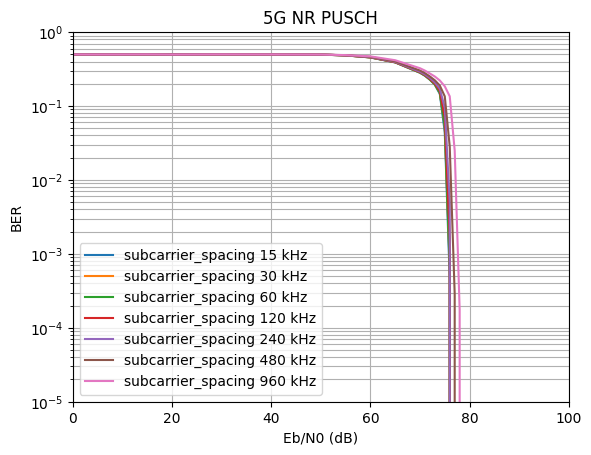

In [19]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([PUSCH_SIMS3["ebno_db"][0], PUSCH_SIMS3["ebno_db"][-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for subcarrier_spacing in PUSCH_SIMS3["subcarrier_spacing"]:
    
    plt.semilogy(PUSCH_SIMS3["ebno_db"], PUSCH_SIMS3["ber"][i])
    i += 1
    legend.append("subcarrier_spacing " + str(int(subcarrier_spacing/1000)) + " kHz" )
   
plt.legend(legend);

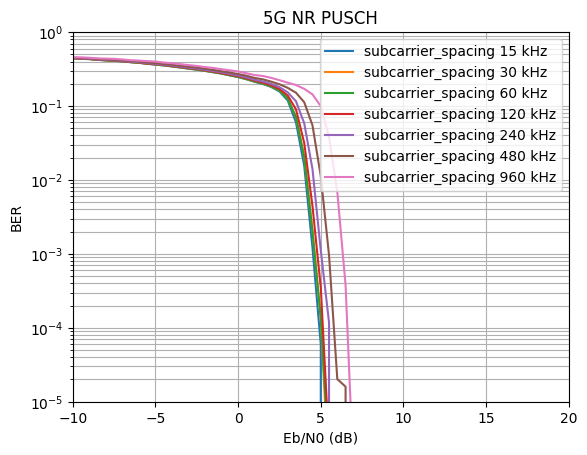

In [20]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([PUSCH_SIMS4["ebno_db"][0], PUSCH_SIMS4["ebno_db"][-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for subcarrier_spacing in PUSCH_SIMS4["subcarrier_spacing"]:
    
    plt.semilogy(PUSCH_SIMS4["ebno_db"], PUSCH_SIMS4["ber"][i])
    i += 1
    legend.append("subcarrier_spacing " + str(int(subcarrier_spacing/1000)) + " kHz" )
   
plt.legend(legend);